# $\textbf{Part 1. Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

#### $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

#### $\textbf{Prediction of LFSR State }n + 1\textbf{ Given State }n$
$\text{Suppose we are given an arbitrary LFSR feedback polynomial and we build a representation of the LFSR in software. Using this LFSR, and}$
$\text{assuming the feedback polynomial is primitive in a polynomial ring of fixed degree over }GF(2)\text{, we can generate a maximum-length binary}$
$\text{sequence which has well-documented correlation properties which make them desirable building blocks for stream ciphers or spread-spectrum}$
$\text{codes, to name a few examples. On their own, LFSRs do not afford any real cryptographic protection, being famously susceptible to correlation}$
$\text{attacks. Speaking of attacks, our goal in this notebook is to demonstrate that we can use a }\textit{very}\text{ simple neural network to predict LFSR behavior.}$
$\text{Specifically, we posit that a two-layer (i.e., single hidden-layer) feedforward neural network can readily predict the state-evolution of an arbitrary}$
$\text{LFSR. For simplicity, we constrain this network to have a very specific architecture. Its input layer consists of a fixed-length binary vector that}$
$\text{represents the LFSR state vector at some time index (epoch) }n\text{. We use the ground truth register state at index / epoch }n + 1\text{ to train a the network}$
$\text{to develop a latent representation of the finite field recursion. Both layers of the network are sigmoid connections, representing soft approximations}$
$\text{of boolean gates, outputing activations in the unit interval, }[0,1].\text{ These layers assume no bias terms, only weighted combinations of inputs. For}$
$\text{an LFSR of recursion-order/polynomial degree }deg\text{, the first (and only) hidden layer consists a total of }2\times deg\text{ weighted sigmoidal activations.}$
$\text{The output layer consists of the }deg\text{ total activations predicting }deg\text{ total bits in the LFSR state vector at epoch }n + 1\text{, for all }n\text{. These binary}$
$\text{activations are trained against the true LFSR state vectors at these indices }n + 1\text{ using a binary cross-entropy error function. The population of}$
$\text{observations are the }deg\text{-length LFSR states across all epochs in one full }m\text{-sequence period / cycle. The labels for the error function are the }$
$deg\text{-length state vector values upon 1 iteration of the LFSR recursion, per observation.}$

#### $\textbf{Part 1 of This Notebook}$
$\text{Part 1 of this notebook prototypes a feedforward binary (bias-less) neural network using Keras, training it as described above using RMSprop. The}$
$\text{model is given too few degrees of freedom to completely memorize the bits, so it must learn a latent representation of the underlying finite field}$
$\text{mathematics defining the recurrence relation. After sufficiently many training epochs, the model has been tested to converge to 100}\%\text{ accuracy}$
$\text{for all degree-10 primitive polynomials in the file 10.txt. Primitive polynomials defining }m\text{-sequences for other polynomial degrees are available}$
$\text{for download at the following site: }\textit{https://users.ece.cmu.edu/~koopman/lfsr/index.html}\text{. Future efforts may build this proof-of-concept out to}$
$\text{higher degree recursions and more complicated kinds of stream ciphers. For now, we demonstrate that a relatively shallow binary network is}$
$\text{sufficiently powerful to "crack" (i.e., predict) an LFSR's underlying recursive state vector mapping.}$

$\text{In addition to training the network, we animate the results in a plot which depicts the time-evolution of the LFSR recursion and the neural}$
$\text{network's state predictions. In addition, options are provided for plotting the correlation properties of the }m\text{-sequence training data and the Keras}$
$\text{model metrics vs training epoch, respectively. Documentation and source code for all the functions below can be found in this repo's modules.}$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange, max

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 16 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 16000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg)

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Visualize Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


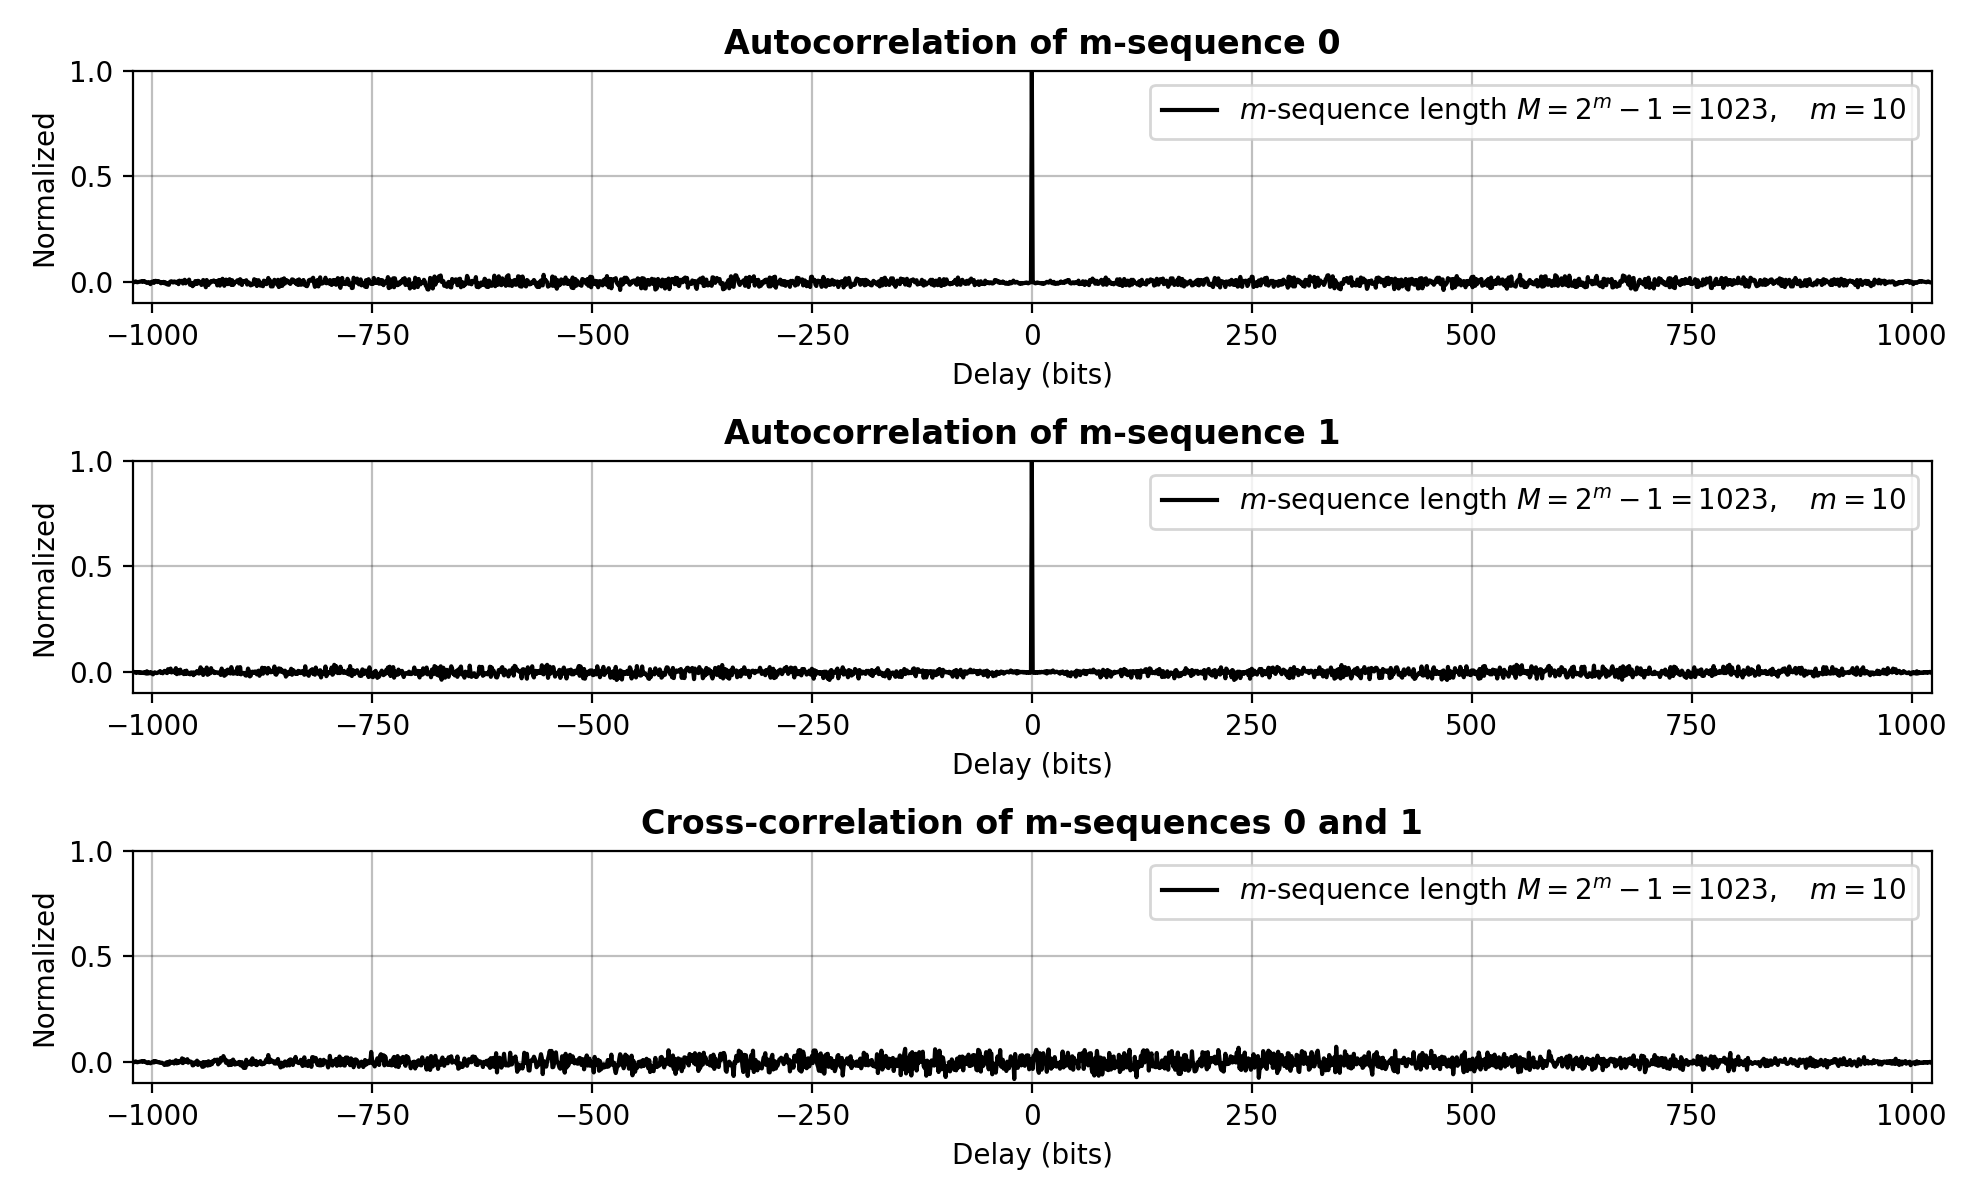

In [5]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Form Observations of }n^{\text{th}}\textbf{ LFSR State for Prediction of }(n + 1)^\text{st}\textbf{ State, for }n=0,1,2,\ldots$

In [6]:
#########################################################
# Buffer in b[n] a total of 2^deg + deg m-sequence bits #
#########################################################

# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))

########################################################
# n'th LFSR register state observations, n = 0,1,2,... #
########################################################

# Input LFSR windows (deg-bit observation vectors)
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])

############################################################
# (n+1)'st LFSR register state observations, n = 0,1,2,... #
############################################################

# Target LFSR windows, 1 epoch into future from X
Y = array([b[p,(n + 1):(1 + n + deg)] for n in range(b.shape[1] - deg - 1)])

### $\textbf{Define Feedforward Binary Neural Network}$

In [7]:
# Use Keras to define feedforward binary neural network, with
# two sigmoidal layers (without bias terms) for estimation of
# the LFSR state vector at epoch n + 1 from the state at epoch n
model = feedforward_lfsr_predictor(deg=deg, 
    learning_rate=learning_rate, print_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 20)                200       
_________________________________________________________________
output (Dense)               (None, 10)                200       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False);

Train on 1023 samples
Epoch 1/16000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7581 - true_positives: 3427.0000 - true_negatives: 1710.0000 - false_positives: 3400.0000 - false_negatives: 1693.0000
Epoch 2/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7527 - true_positives: 3409.0000 - true_negatives: 1732.0000 - false_positives: 3378.0000 - false_negatives: 1711.0000
Epoch 3/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7489 - true_positives: 3406.0000 - true_negatives: 1738.0000 - false_positives: 3372.0000 - false_negatives: 1714.0000
Epoch 4/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7460 - true_positives: 3403.0000 - true_negatives: 1742.0000 - false_positives: 3368.0000 - false_negatives: 1717.0000
Epoch 5/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7434 - true_positives: 3401.0000 - true_negatives: 1747.0000 - false_positives: 3363.00

Epoch 42/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6994 - true_positives: 3365.0000 - true_negatives: 2056.0000 - false_positives: 3054.0000 - false_negatives: 1755.0000
Epoch 43/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6986 - true_positives: 3359.0000 - true_negatives: 2071.0000 - false_positives: 3039.0000 - false_negatives: 1761.0000
Epoch 44/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6979 - true_positives: 3354.0000 - true_negatives: 2097.0000 - false_positives: 3013.0000 - false_negatives: 1766.0000
Epoch 45/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6971 - true_positives: 3348.0000 - true_negatives: 2119.0000 - false_positives: 2991.0000 - false_negatives: 1772.0000
Epoch 46/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6964 - true_positives: 3342.0000 - true_negatives: 2139.0000 - false_positives: 2971.0000 - false_negati

Epoch 83/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6746 - true_positives: 3360.0000 - true_negatives: 2978.0000 - false_positives: 2132.0000 - false_negatives: 1760.0000
Epoch 84/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6741 - true_positives: 3366.0000 - true_negatives: 2986.0000 - false_positives: 2124.0000 - false_negatives: 1754.0000
Epoch 85/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6736 - true_positives: 3376.0000 - true_negatives: 2993.0000 - false_positives: 2117.0000 - false_negatives: 1744.0000
Epoch 86/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6731 - true_positives: 3389.0000 - true_negatives: 3011.0000 - false_positives: 2099.0000 - false_negatives: 1731.0000
Epoch 87/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6727 - true_positives: 3402.0000 - true_negatives: 3023.0000 - false_positives: 2087.0000 - false_negati

Epoch 124/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6562 - true_positives: 3809.0000 - true_negatives: 3522.0000 - false_positives: 1588.0000 - false_negatives: 1311.0000
Epoch 125/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6557 - true_positives: 3819.0000 - true_negatives: 3533.0000 - false_positives: 1577.0000 - false_negatives: 1301.0000
Epoch 126/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6553 - true_positives: 3822.0000 - true_negatives: 3548.0000 - false_positives: 1562.0000 - false_negatives: 1298.0000
Epoch 127/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6549 - true_positives: 3827.0000 - true_negatives: 3560.0000 - false_positives: 1550.0000 - false_negatives: 1293.0000
Epoch 128/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6544 - true_positives: 3836.0000 - true_negatives: 3572.0000 - false_positives: 1538.0000 - false_n

Epoch 165/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6379 - true_positives: 4130.0000 - true_negatives: 3907.0000 - false_positives: 1203.0000 - false_negatives: 990.0000
Epoch 166/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6375 - true_positives: 4108.0000 - true_negatives: 3938.0000 - false_positives: 1172.0000 - false_negatives: 1012.0000
Epoch 167/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6370 - true_positives: 4141.0000 - true_negatives: 3929.0000 - false_positives: 1181.0000 - false_negatives: 979.0000
Epoch 168/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6366 - true_positives: 4139.0000 - true_negatives: 3942.0000 - false_positives: 1168.0000 - false_negatives: 981.0000
Epoch 169/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6361 - true_positives: 4153.0000 - true_negatives: 3943.0000 - false_positives: 1167.0000 - false_nega

Epoch 206/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6192 - true_positives: 4367.0000 - true_negatives: 4165.0000 - false_positives: 945.0000 - false_negatives: 753.0000
Epoch 207/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6187 - true_positives: 4385.0000 - true_negatives: 4153.0000 - false_positives: 957.0000 - false_negatives: 735.0000
Epoch 208/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6182 - true_positives: 4375.0000 - true_negatives: 4174.0000 - false_positives: 936.0000 - false_negatives: 745.0000
Epoch 209/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6178 - true_positives: 4397.0000 - true_negatives: 4160.0000 - false_positives: 950.0000 - false_negatives: 723.0000
Epoch 210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6173 - true_positives: 4388.0000 - true_negatives: 4188.0000 - false_positives: 922.0000 - false_negatives:

Epoch 247/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5997 - true_positives: 4535.0000 - true_negatives: 4293.0000 - false_positives: 817.0000 - false_negatives: 585.0000
Epoch 248/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5993 - true_positives: 4523.0000 - true_negatives: 4315.0000 - false_positives: 795.0000 - false_negatives: 597.0000
Epoch 249/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5988 - true_positives: 4545.0000 - true_negatives: 4301.0000 - false_positives: 809.0000 - false_negatives: 575.0000
Epoch 250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5983 - true_positives: 4532.0000 - true_negatives: 4320.0000 - false_positives: 790.0000 - false_negatives: 588.0000
Epoch 251/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5978 - true_positives: 4551.0000 - true_negatives: 4307.0000 - false_positives: 803.0000 - false_negatives:

Epoch 288/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5796 - true_positives: 4601.0000 - true_negatives: 4434.0000 - false_positives: 676.0000 - false_negatives: 519.0000
Epoch 289/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5791 - true_positives: 4622.0000 - true_negatives: 4420.0000 - false_positives: 690.0000 - false_negatives: 498.0000
Epoch 290/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5786 - true_positives: 4604.0000 - true_negatives: 4439.0000 - false_positives: 671.0000 - false_negatives: 516.0000
Epoch 291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5781 - true_positives: 4628.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negatives: 492.0000
Epoch 292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5776 - true_positives: 4607.0000 - true_negatives: 4445.0000 - false_positives: 665.0000 - false_negatives:

Epoch 329/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5588 - true_positives: 4666.0000 - true_negatives: 4502.0000 - false_positives: 608.0000 - false_negatives: 454.0000
Epoch 330/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5583 - true_positives: 4643.0000 - true_negatives: 4525.0000 - false_positives: 585.0000 - false_negatives: 477.0000
Epoch 331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5578 - true_positives: 4668.0000 - true_negatives: 4505.0000 - false_positives: 605.0000 - false_negatives: 452.0000
Epoch 332/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5573 - true_positives: 4646.0000 - true_negatives: 4527.0000 - false_positives: 583.0000 - false_negatives: 474.0000
Epoch 333/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5568 - true_positives: 4670.0000 - true_negatives: 4507.0000 - false_positives: 603.0000 - false_negatives:

Epoch 370/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5376 - true_positives: 4681.0000 - true_negatives: 4591.0000 - false_positives: 519.0000 - false_negatives: 439.0000
Epoch 371/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5370 - true_positives: 4704.0000 - true_negatives: 4559.0000 - false_positives: 551.0000 - false_negatives: 416.0000
Epoch 372/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5365 - true_positives: 4682.0000 - true_negatives: 4595.0000 - false_positives: 515.0000 - false_negatives: 438.0000
Epoch 373/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5360 - true_positives: 4708.0000 - true_negatives: 4560.0000 - false_positives: 550.0000 - false_negatives: 412.0000
Epoch 374/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5355 - true_positives: 4681.0000 - true_negatives: 4595.0000 - false_positives: 515.0000 - false_negatives:

Epoch 411/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5159 - true_positives: 4748.0000 - true_negatives: 4594.0000 - false_positives: 516.0000 - false_negatives: 372.0000
Epoch 412/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5154 - true_positives: 4701.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 419.0000
Epoch 413/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5149 - true_positives: 4747.0000 - true_negatives: 4596.0000 - false_positives: 514.0000 - false_negatives: 373.0000
Epoch 414/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5143 - true_positives: 4700.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 420.0000
Epoch 415/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5138 - true_positives: 4749.0000 - true_negatives: 4595.0000 - false_positives: 515.0000 - false_negatives:

Epoch 452/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4940 - true_positives: 4719.0000 - true_negatives: 4689.0000 - false_positives: 421.0000 - false_negatives: 401.0000
Epoch 453/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4935 - true_positives: 4789.0000 - true_negatives: 4615.0000 - false_positives: 495.0000 - false_negatives: 331.0000
Epoch 454/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4929 - true_positives: 4721.0000 - true_negatives: 4691.0000 - false_positives: 419.0000 - false_negatives: 399.0000
Epoch 455/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4924 - true_positives: 4790.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 330.0000
Epoch 456/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4919 - true_positives: 4722.0000 - true_negatives: 4695.0000 - false_positives: 415.0000 - false_negatives:

Epoch 493/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4721 - true_positives: 4821.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 299.0000
Epoch 494/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4715 - true_positives: 4727.0000 - true_negatives: 4737.0000 - false_positives: 373.0000 - false_negatives: 393.0000
Epoch 495/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4710 - true_positives: 4822.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 298.0000
Epoch 496/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4705 - true_positives: 4724.0000 - true_negatives: 4739.0000 - false_positives: 371.0000 - false_negatives: 396.0000
Epoch 497/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4699 - true_positives: 4825.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives:

Epoch 534/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4503 - true_positives: 4734.0000 - true_negatives: 4760.0000 - false_positives: 350.0000 - false_negatives: 386.0000
Epoch 535/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4498 - true_positives: 4838.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negatives: 282.0000
Epoch 536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4492 - true_positives: 4736.0000 - true_negatives: 4761.0000 - false_positives: 349.0000 - false_negatives: 384.0000
Epoch 537/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4487 - true_positives: 4846.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 274.0000
Epoch 538/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4482 - true_positives: 4735.0000 - true_negatives: 4766.0000 - false_positives: 344.0000 - false_negatives:

Epoch 575/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4289 - true_positives: 4866.0000 - true_negatives: 4679.0000 - false_positives: 431.0000 - false_negatives: 254.0000
Epoch 576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4283 - true_positives: 4741.0000 - true_negatives: 4790.0000 - false_positives: 320.0000 - false_negatives: 379.0000
Epoch 577/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4278 - true_positives: 4865.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negatives: 255.0000
Epoch 578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4273 - true_positives: 4740.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 380.0000
Epoch 579/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4268 - true_positives: 4864.0000 - true_negatives: 4686.0000 - false_positives: 424.0000 - false_negatives:

Epoch 616/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4079 - true_positives: 4761.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 359.0000
Epoch 617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4074 - true_positives: 4873.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 247.0000
Epoch 618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4069 - true_positives: 4761.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 359.0000
Epoch 619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4064 - true_positives: 4873.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 247.0000
Epoch 620/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4059 - true_positives: 4762.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives:

Epoch 657/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3875 - true_positives: 4871.0000 - true_negatives: 4739.0000 - false_positives: 371.0000 - false_negatives: 249.0000
Epoch 658/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3870 - true_positives: 4773.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 347.0000
Epoch 659/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3865 - true_positives: 4871.0000 - true_negatives: 4741.0000 - false_positives: 369.0000 - false_negatives: 249.0000
Epoch 660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3860 - true_positives: 4773.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 347.0000
Epoch 661/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3855 - true_positives: 4872.0000 - true_negatives: 4740.0000 - false_positives: 370.0000 - false_negatives:

Epoch 698/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3677 - true_positives: 4779.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 341.0000
Epoch 699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3673 - true_positives: 4883.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 237.0000
Epoch 700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3668 - true_positives: 4779.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives: 341.0000
Epoch 701/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3663 - true_positives: 4884.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negatives: 236.0000
Epoch 702/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3659 - true_positives: 4780.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives:

Epoch 739/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3487 - true_positives: 4896.0000 - true_negatives: 4757.0000 - false_positives: 353.0000 - false_negatives: 224.0000
Epoch 740/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3482 - true_positives: 4789.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 331.0000
Epoch 741/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3478 - true_positives: 4896.0000 - true_negatives: 4758.0000 - false_positives: 352.0000 - false_negatives: 224.0000
Epoch 742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3473 - true_positives: 4791.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 329.0000
Epoch 743/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3469 - true_positives: 4897.0000 - true_negatives: 4759.0000 - false_positives: 351.0000 - false_negatives:

Epoch 780/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3304 - true_positives: 4807.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 313.0000
Epoch 781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3300 - true_positives: 4899.0000 - true_negatives: 4769.0000 - false_positives: 341.0000 - false_negatives: 221.0000
Epoch 782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3296 - true_positives: 4808.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 312.0000
Epoch 783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3291 - true_positives: 4899.0000 - true_negatives: 4768.0000 - false_positives: 342.0000 - false_negatives: 221.0000
Epoch 784/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3287 - true_positives: 4807.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives:

Epoch 821/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3130 - true_positives: 4908.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 212.0000
Epoch 822/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3126 - true_positives: 4829.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 291.0000
Epoch 823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3122 - true_positives: 4907.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 213.0000
Epoch 824/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3118 - true_positives: 4828.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 292.0000
Epoch 825/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3114 - true_positives: 4906.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives:

Epoch 862/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2965 - true_positives: 4834.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 286.0000
Epoch 863/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2961 - true_positives: 4909.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 211.0000
Epoch 864/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2957 - true_positives: 4834.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 286.0000
Epoch 865/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2953 - true_positives: 4910.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 210.0000
Epoch 866/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2949 - true_positives: 4834.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives:

Epoch 903/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2808 - true_positives: 4909.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 211.0000
Epoch 904/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2804 - true_positives: 4843.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 277.0000
Epoch 905/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2801 - true_positives: 4910.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 210.0000
Epoch 906/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2797 - true_positives: 4843.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 277.0000
Epoch 907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2793 - true_positives: 4908.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negatives:

Epoch 944/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2660 - true_positives: 4844.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 276.0000
Epoch 945/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2656 - true_positives: 4911.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 209.0000
Epoch 946/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2653 - true_positives: 4843.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 277.0000
Epoch 947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2649 - true_positives: 4912.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negatives: 208.0000
Epoch 948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2646 - true_positives: 4843.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives:

Epoch 985/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2521 - true_positives: 4916.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 204.0000
Epoch 986/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2517 - true_positives: 4843.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 277.0000
Epoch 987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2514 - true_positives: 4916.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 204.0000
Epoch 988/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2511 - true_positives: 4844.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 276.0000
Epoch 989/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2508 - true_positives: 4917.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives:

Epoch 1026/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2390 - true_positives: 4850.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 270.0000
Epoch 1027/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2387 - true_positives: 4922.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 198.0000
Epoch 1028/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2384 - true_positives: 4848.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 272.0000
Epoch 1029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2381 - true_positives: 4923.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 197.0000
Epoch 1030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2378 - true_positives: 4848.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negat

Epoch 1067/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2268 - true_positives: 4919.0000 - true_negatives: 4809.0000 - false_positives: 301.0000 - false_negatives: 201.0000
Epoch 1068/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2266 - true_positives: 4855.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 265.0000
Epoch 1069/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2263 - true_positives: 4919.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 201.0000
Epoch 1070/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2260 - true_positives: 4854.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 266.0000
Epoch 1071/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2257 - true_positives: 4919.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negat

Epoch 1108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2155 - true_positives: 4856.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 264.0000
Epoch 1109/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2152 - true_positives: 4920.0000 - true_negatives: 4809.0000 - false_positives: 301.0000 - false_negatives: 200.0000
Epoch 1110/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2149 - true_positives: 4856.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 264.0000
Epoch 1111/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2147 - true_positives: 4920.0000 - true_negatives: 4809.0000 - false_positives: 301.0000 - false_negatives: 200.0000
Epoch 1112/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2144 - true_positives: 4857.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 1149/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2049 - true_positives: 4919.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 201.0000
Epoch 1150/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2047 - true_positives: 4863.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 257.0000
Epoch 1151/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2044 - true_positives: 4920.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 200.0000
Epoch 1152/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2042 - true_positives: 4863.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 257.0000
Epoch 1153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2039 - true_positives: 4921.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negat

Epoch 1190/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1951 - true_positives: 4863.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 257.0000
Epoch 1191/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1949 - true_positives: 4925.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negatives: 195.0000
Epoch 1192/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1946 - true_positives: 4864.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 256.0000
Epoch 1193/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1944 - true_positives: 4924.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negatives: 196.0000
Epoch 1194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1942 - true_positives: 4865.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 1231/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1860 - true_positives: 4920.0000 - true_negatives: 4813.0000 - false_positives: 297.0000 - false_negatives: 200.0000
Epoch 1232/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1858 - true_positives: 4867.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 253.0000
Epoch 1233/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1856 - true_positives: 4920.0000 - true_negatives: 4813.0000 - false_positives: 297.0000 - false_negatives: 200.0000
Epoch 1234/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1853 - true_positives: 4868.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 252.0000
Epoch 1235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1851 - true_positives: 4920.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negat

Epoch 1272/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1776 - true_positives: 4868.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 252.0000
Epoch 1273/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1774 - true_positives: 4918.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 202.0000
Epoch 1274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1772 - true_positives: 4870.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 250.0000
Epoch 1275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1770 - true_positives: 4918.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 202.0000
Epoch 1276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1768 - true_positives: 4869.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 1313/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1698 - true_positives: 4909.0000 - true_negatives: 4811.0000 - false_positives: 299.0000 - false_negatives: 211.0000
Epoch 1314/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1696 - true_positives: 4876.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 244.0000
Epoch 1315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1694 - true_positives: 4911.0000 - true_negatives: 4811.0000 - false_positives: 299.0000 - false_negatives: 209.0000
Epoch 1316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1692 - true_positives: 4875.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 245.0000
Epoch 1317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1690 - true_positives: 4911.0000 - true_negatives: 4811.0000 - false_positives: 299.0000 - false_negat

Epoch 1354/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1626 - true_positives: 4877.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 243.0000
Epoch 1355/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1624 - true_positives: 4912.0000 - true_negatives: 4813.0000 - false_positives: 297.0000 - false_negatives: 208.0000
Epoch 1356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1622 - true_positives: 4876.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 244.0000
Epoch 1357/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1621 - true_positives: 4912.0000 - true_negatives: 4813.0000 - false_positives: 297.0000 - false_negatives: 208.0000
Epoch 1358/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1619 - true_positives: 4876.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negat

Epoch 1395/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1559 - true_positives: 4915.0000 - true_negatives: 4815.0000 - false_positives: 295.0000 - false_negatives: 205.0000
Epoch 1396/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1558 - true_positives: 4871.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 249.0000
Epoch 1397/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1556 - true_positives: 4914.0000 - true_negatives: 4815.0000 - false_positives: 295.0000 - false_negatives: 206.0000
Epoch 1398/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1555 - true_positives: 4871.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 249.0000
Epoch 1399/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1553 - true_positives: 4912.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negat

Epoch 1436/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1498 - true_positives: 4872.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 248.0000
Epoch 1437/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1497 - true_positives: 4912.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negatives: 208.0000
Epoch 1438/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1495 - true_positives: 4872.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 248.0000
Epoch 1439/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1494 - true_positives: 4911.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negatives: 209.0000
Epoch 1440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1493 - true_positives: 4872.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 1477/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1442 - true_positives: 4909.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 211.0000
Epoch 1478/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1441 - true_positives: 4874.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 246.0000
Epoch 1479/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1439 - true_positives: 4909.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 211.0000
Epoch 1480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1438 - true_positives: 4874.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 246.0000
Epoch 1481/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1437 - true_positives: 4908.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negat

Epoch 1518/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1390 - true_positives: 4876.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 244.0000
Epoch 1519/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1389 - true_positives: 4907.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 213.0000
Epoch 1520/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1388 - true_positives: 4875.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 245.0000
Epoch 1521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1387 - true_positives: 4906.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 214.0000
Epoch 1522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1386 - true_positives: 4875.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 1559/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1343 - true_positives: 4905.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 215.0000
Epoch 1560/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1342 - true_positives: 4877.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 243.0000
Epoch 1561/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1341 - true_positives: 4905.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 215.0000
Epoch 1562/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1340 - true_positives: 4876.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 244.0000
Epoch 1563/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1338 - true_positives: 4905.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negat

Epoch 1600/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1299 - true_positives: 4876.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 244.0000
Epoch 1601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1298 - true_positives: 4907.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 213.0000
Epoch 1602/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1297 - true_positives: 4874.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 246.0000
Epoch 1603/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1296 - true_positives: 4908.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 212.0000
Epoch 1604/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1295 - true_positives: 4874.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 1641/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1259 - true_positives: 4907.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 213.0000
Epoch 1642/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1258 - true_positives: 4877.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 243.0000
Epoch 1643/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1257 - true_positives: 4907.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 213.0000
Epoch 1644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1256 - true_positives: 4876.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 244.0000
Epoch 1645/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1255 - true_positives: 4908.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 1682/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1222 - true_positives: 4876.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 244.0000
Epoch 1683/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1221 - true_positives: 4905.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 215.0000
Epoch 1684/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1220 - true_positives: 4876.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 244.0000
Epoch 1685/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1219 - true_positives: 4904.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 216.0000
Epoch 1686/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1218 - true_positives: 4876.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 1723/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1188 - true_positives: 4904.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 216.0000
Epoch 1724/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1187 - true_positives: 4875.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 245.0000
Epoch 1725/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1186 - true_positives: 4904.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 216.0000
Epoch 1726/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1185 - true_positives: 4875.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 245.0000
Epoch 1727/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1184 - true_positives: 4903.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negat

Epoch 1764/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1156 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 246.0000
Epoch 1765/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1155 - true_positives: 4902.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 218.0000
Epoch 1766/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1155 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 246.0000
Epoch 1767/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1154 - true_positives: 4902.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 218.0000
Epoch 1768/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1153 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 1805/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1127 - true_positives: 4903.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 217.0000
Epoch 1806/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1126 - true_positives: 4871.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 249.0000
Epoch 1807/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1126 - true_positives: 4902.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 218.0000
Epoch 1808/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1125 - true_positives: 4872.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 248.0000
Epoch 1809/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1124 - true_positives: 4902.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negat

Epoch 1846/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1100 - true_positives: 4872.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 248.0000
Epoch 1847/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1099 - true_positives: 4903.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 217.0000
Epoch 1848/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1099 - true_positives: 4872.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 248.0000
Epoch 1849/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1098 - true_positives: 4902.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 218.0000
Epoch 1850/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1097 - true_positives: 4872.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 1887/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1075 - true_positives: 4902.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 218.0000
Epoch 1888/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1074 - true_positives: 4876.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 244.0000
Epoch 1889/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1074 - true_positives: 4900.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 220.0000
Epoch 1890/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1073 - true_positives: 4876.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 244.0000
Epoch 1891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1073 - true_positives: 4900.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negat

Epoch 1928/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1052 - true_positives: 4876.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 244.0000
Epoch 1929/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1051 - true_positives: 4902.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 218.0000
Epoch 1930/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1051 - true_positives: 4877.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 243.0000
Epoch 1931/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1050 - true_positives: 4901.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 219.0000
Epoch 1932/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1050 - true_positives: 4878.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negat

Epoch 1969/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1030 - true_positives: 4904.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 216.0000
Epoch 1970/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1030 - true_positives: 4881.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 239.0000
Epoch 1971/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1029 - true_positives: 4904.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 216.0000
Epoch 1972/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1029 - true_positives: 4881.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 239.0000
Epoch 1973/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1028 - true_positives: 4904.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negat

Epoch 2010/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1010 - true_positives: 4879.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 241.0000
Epoch 2011/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1010 - true_positives: 4902.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 218.0000
Epoch 2012/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1010 - true_positives: 4879.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 241.0000
Epoch 2013/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1009 - true_positives: 4902.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 218.0000
Epoch 2014/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1009 - true_positives: 4879.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negat

Epoch 2051/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4903.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 217.0000
Epoch 2052/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4878.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 242.0000
Epoch 2053/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0991 - true_positives: 4903.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 217.0000
Epoch 2054/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0991 - true_positives: 4878.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 242.0000
Epoch 2055/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0990 - true_positives: 4903.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negat

Epoch 2092/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0975 - true_positives: 4873.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 247.0000
Epoch 2093/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0974 - true_positives: 4899.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 221.0000
Epoch 2094/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0974 - true_positives: 4874.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 246.0000
Epoch 2095/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0974 - true_positives: 4895.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 225.0000
Epoch 2096/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0973 - true_positives: 4874.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 2133/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0959 - true_positives: 4896.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 224.0000
Epoch 2134/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0958 - true_positives: 4872.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 248.0000
Epoch 2135/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0958 - true_positives: 4896.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 224.0000
Epoch 2136/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0958 - true_positives: 4872.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 248.0000
Epoch 2137/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0957 - true_positives: 4896.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negat

Epoch 2174/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0944 - true_positives: 4869.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 251.0000
Epoch 2175/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0944 - true_positives: 4892.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 228.0000
Epoch 2176/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0943 - true_positives: 4869.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 251.0000
Epoch 2177/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0943 - true_positives: 4891.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 229.0000
Epoch 2178/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0942 - true_positives: 4869.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negat

Epoch 2215/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0930 - true_positives: 4886.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negatives: 234.0000
Epoch 2216/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0930 - true_positives: 4869.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 251.0000
Epoch 2217/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0929 - true_positives: 4886.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negatives: 234.0000
Epoch 2218/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0929 - true_positives: 4869.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 251.0000
Epoch 2219/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0929 - true_positives: 4887.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negat

Epoch 2256/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0917 - true_positives: 4870.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 250.0000
Epoch 2257/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0917 - true_positives: 4889.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 231.0000
Epoch 2258/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0916 - true_positives: 4870.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 250.0000
Epoch 2259/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0916 - true_positives: 4890.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 230.0000
Epoch 2260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0916 - true_positives: 4872.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 2297/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0905 - true_positives: 4893.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 227.0000
Epoch 2298/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0904 - true_positives: 4870.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 250.0000
Epoch 2299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0904 - true_positives: 4893.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 227.0000
Epoch 2300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0904 - true_positives: 4871.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 249.0000
Epoch 2301/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0903 - true_positives: 4890.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negat

Epoch 2338/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0893 - true_positives: 4873.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 247.0000
Epoch 2339/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0893 - true_positives: 4890.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 230.0000
Epoch 2340/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0892 - true_positives: 4873.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 247.0000
Epoch 2341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0892 - true_positives: 4892.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 228.0000
Epoch 2342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0892 - true_positives: 4873.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negat

Epoch 2379/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0882 - true_positives: 4890.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 230.0000
Epoch 2380/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4873.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 247.0000
Epoch 2381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0882 - true_positives: 4890.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 230.0000
Epoch 2382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0881 - true_positives: 4873.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 247.0000
Epoch 2383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0881 - true_positives: 4891.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negat

Epoch 2420/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0872 - true_positives: 4873.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 247.0000
Epoch 2421/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0872 - true_positives: 4891.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 229.0000
Epoch 2422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0871 - true_positives: 4873.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 247.0000
Epoch 2423/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0871 - true_positives: 4891.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 229.0000
Epoch 2424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0871 - true_positives: 4873.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negat

Epoch 2461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0862 - true_positives: 4893.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 227.0000
Epoch 2462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0862 - true_positives: 4877.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 243.0000
Epoch 2463/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0862 - true_positives: 4893.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 227.0000
Epoch 2464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0862 - true_positives: 4877.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 243.0000
Epoch 2465/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0861 - true_positives: 4894.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negat

Epoch 2502/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0853 - true_positives: 4878.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 242.0000
Epoch 2503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0853 - true_positives: 4892.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 228.0000
Epoch 2504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0853 - true_positives: 4878.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 242.0000
Epoch 2505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0852 - true_positives: 4892.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 228.0000
Epoch 2506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0852 - true_positives: 4879.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negat

Epoch 2543/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0844 - true_positives: 4894.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 226.0000
Epoch 2544/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0844 - true_positives: 4879.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 241.0000
Epoch 2545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0844 - true_positives: 4894.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 226.0000
Epoch 2546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0844 - true_positives: 4879.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 241.0000
Epoch 2547/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0843 - true_positives: 4895.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 2584/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0836 - true_positives: 4879.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 241.0000
Epoch 2585/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0836 - true_positives: 4889.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 231.0000
Epoch 2586/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0835 - true_positives: 4879.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 241.0000
Epoch 2587/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0835 - true_positives: 4889.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 231.0000
Epoch 2588/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0835 - true_positives: 4880.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negat

Epoch 2625/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0828 - true_positives: 4890.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 230.0000
Epoch 2626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0828 - true_positives: 4880.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 240.0000
Epoch 2627/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0828 - true_positives: 4890.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 230.0000
Epoch 2628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0827 - true_positives: 4879.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 241.0000
Epoch 2629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0827 - true_positives: 4890.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negat

Epoch 2666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0820 - true_positives: 4874.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 246.0000
Epoch 2667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0820 - true_positives: 4889.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 231.0000
Epoch 2668/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0820 - true_positives: 4874.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 246.0000
Epoch 2669/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4889.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 231.0000
Epoch 2670/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4874.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negat

Epoch 2707/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0813 - true_positives: 4886.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 234.0000
Epoch 2708/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0813 - true_positives: 4876.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 244.0000
Epoch 2709/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0813 - true_positives: 4886.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 234.0000
Epoch 2710/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0812 - true_positives: 4876.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 244.0000
Epoch 2711/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0812 - true_positives: 4886.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negat

Epoch 2748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0806 - true_positives: 4877.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 243.0000
Epoch 2749/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0806 - true_positives: 4886.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 234.0000
Epoch 2750/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0806 - true_positives: 4877.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 243.0000
Epoch 2751/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0805 - true_positives: 4886.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 234.0000
Epoch 2752/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0805 - true_positives: 4878.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negat

Epoch 2789/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0799 - true_positives: 4888.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 232.0000
Epoch 2790/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0799 - true_positives: 4879.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 241.0000
Epoch 2791/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0799 - true_positives: 4888.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 232.0000
Epoch 2792/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0799 - true_positives: 4879.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 241.0000
Epoch 2793/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0798 - true_positives: 4888.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negat

Epoch 2830/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4879.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 241.0000
Epoch 2831/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4892.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 228.0000
Epoch 2832/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4879.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 241.0000
Epoch 2833/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4893.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 227.0000
Epoch 2834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4879.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negat

Epoch 2871/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0786 - true_positives: 4896.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 224.0000
Epoch 2872/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0786 - true_positives: 4885.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 235.0000
Epoch 2873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0786 - true_positives: 4896.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 224.0000
Epoch 2874/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0786 - true_positives: 4885.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 235.0000
Epoch 2875/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0785 - true_positives: 4896.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negat

Epoch 2912/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0780 - true_positives: 4889.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 231.0000
Epoch 2913/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0780 - true_positives: 4898.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 222.0000
Epoch 2914/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0780 - true_positives: 4889.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 231.0000
Epoch 2915/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0779 - true_positives: 4898.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 222.0000
Epoch 2916/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0779 - true_positives: 4889.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negat

Epoch 2953/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4897.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 223.0000
Epoch 2954/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4893.0000 - true_negatives: 4921.0000 - false_positives: 189.0000 - false_negatives: 227.0000
Epoch 2955/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4897.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 223.0000
Epoch 2956/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0773 - true_positives: 4893.0000 - true_negatives: 4921.0000 - false_positives: 189.0000 - false_negatives: 227.0000
Epoch 2957/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0773 - true_positives: 4897.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negat

Epoch 2994/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0768 - true_positives: 4894.0000 - true_negatives: 4921.0000 - false_positives: 189.0000 - false_negatives: 226.0000
Epoch 2995/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0768 - true_positives: 4897.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 223.0000
Epoch 2996/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0768 - true_positives: 4894.0000 - true_negatives: 4921.0000 - false_positives: 189.0000 - false_negatives: 226.0000
Epoch 2997/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0768 - true_positives: 4897.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 223.0000
Epoch 2998/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0768 - true_positives: 4894.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negat

Epoch 3035/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4898.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 222.0000
Epoch 3036/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4894.0000 - true_negatives: 4923.0000 - false_positives: 187.0000 - false_negatives: 226.0000
Epoch 3037/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4898.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 222.0000
Epoch 3038/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4894.0000 - true_negatives: 4923.0000 - false_positives: 187.0000 - false_negatives: 226.0000
Epoch 3039/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4898.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negat

Epoch 3076/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0757 - true_positives: 4897.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negatives: 223.0000
Epoch 3077/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0757 - true_positives: 4902.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 218.0000
Epoch 3078/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0757 - true_positives: 4897.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negatives: 223.0000
Epoch 3079/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0756 - true_positives: 4901.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 219.0000
Epoch 3080/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0756 - true_positives: 4897.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negat

Epoch 3117/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0751 - true_positives: 4903.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negatives: 217.0000
Epoch 3118/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4900.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negatives: 220.0000
Epoch 3119/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4903.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negatives: 217.0000
Epoch 3120/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4901.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 219.0000
Epoch 3121/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4903.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negat

Epoch 3158/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0746 - true_positives: 4900.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 220.0000
Epoch 3159/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0746 - true_positives: 4907.0000 - true_negatives: 4925.0000 - false_positives: 185.0000 - false_negatives: 213.0000
Epoch 3160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0746 - true_positives: 4900.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 220.0000
Epoch 3161/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0746 - true_positives: 4907.0000 - true_negatives: 4926.0000 - false_positives: 184.0000 - false_negatives: 213.0000
Epoch 3162/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0746 - true_positives: 4900.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negat

Epoch 3199/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0741 - true_positives: 4912.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 208.0000
Epoch 3200/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0741 - true_positives: 4903.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 217.0000
Epoch 3201/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0741 - true_positives: 4912.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 208.0000
Epoch 3202/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0741 - true_positives: 4903.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 217.0000
Epoch 3203/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0740 - true_positives: 4912.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negat

Epoch 3240/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0736 - true_positives: 4909.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 211.0000
Epoch 3241/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0736 - true_positives: 4912.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 208.0000
Epoch 3242/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0736 - true_positives: 4909.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 211.0000
Epoch 3243/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0735 - true_positives: 4914.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 206.0000
Epoch 3244/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0735 - true_positives: 4909.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negat

Epoch 3281/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0731 - true_positives: 4916.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 204.0000
Epoch 3282/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0731 - true_positives: 4909.0000 - true_negatives: 4943.0000 - false_positives: 167.0000 - false_negatives: 211.0000
Epoch 3283/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0731 - true_positives: 4916.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 204.0000
Epoch 3284/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0730 - true_positives: 4909.0000 - true_negatives: 4942.0000 - false_positives: 168.0000 - false_negatives: 211.0000
Epoch 3285/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0730 - true_positives: 4916.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negat

Epoch 3322/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0726 - true_positives: 4913.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 207.0000
Epoch 3323/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0726 - true_positives: 4919.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 201.0000
Epoch 3324/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0725 - true_positives: 4913.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 207.0000
Epoch 3325/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0725 - true_positives: 4919.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 201.0000
Epoch 3326/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0725 - true_positives: 4913.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negat

Epoch 3363/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0721 - true_positives: 4919.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 201.0000
Epoch 3364/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0721 - true_positives: 4917.0000 - true_negatives: 4950.0000 - false_positives: 160.0000 - false_negatives: 203.0000
Epoch 3365/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4920.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 200.0000
Epoch 3366/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4917.0000 - true_negatives: 4950.0000 - false_positives: 160.0000 - false_negatives: 203.0000
Epoch 3367/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4920.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negat

Epoch 3404/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0716 - true_positives: 4918.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 202.0000
Epoch 3405/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0716 - true_positives: 4922.0000 - true_negatives: 4948.0000 - false_positives: 162.0000 - false_negatives: 198.0000
Epoch 3406/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0716 - true_positives: 4918.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 202.0000
Epoch 3407/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 4922.0000 - true_negatives: 4948.0000 - false_positives: 162.0000 - false_negatives: 198.0000
Epoch 3408/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 4918.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negat

Epoch 3445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4925.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 195.0000
Epoch 3446/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4920.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 200.0000
Epoch 3447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4927.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 193.0000
Epoch 3448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0710 - true_positives: 4920.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 200.0000
Epoch 3449/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 4927.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negat

Epoch 3486/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0706 - true_positives: 4927.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 193.0000
Epoch 3487/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0706 - true_positives: 4929.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 191.0000
Epoch 3488/16000
1023/1023 [==============================] - 0s 12us/sample - loss: 0.0706 - true_positives: 4927.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 193.0000
Epoch 3489/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0706 - true_positives: 4930.0000 - true_negatives: 4956.0000 - false_positives: 154.0000 - false_negatives: 190.0000
Epoch 3490/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0705 - true_positives: 4927.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_nega

Epoch 3527/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4938.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 182.0000
Epoch 3528/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0701 - true_positives: 4932.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 188.0000
Epoch 3529/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4938.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 182.0000
Epoch 3530/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0701 - true_positives: 4933.0000 - true_negatives: 4959.0000 - false_positives: 151.0000 - false_negatives: 187.0000
Epoch 3531/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 4938.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negat

Epoch 3568/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4938.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negatives: 182.0000
Epoch 3569/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0696 - true_positives: 4944.0000 - true_negatives: 4959.0000 - false_positives: 151.0000 - false_negatives: 176.0000
Epoch 3570/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4939.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negatives: 181.0000
Epoch 3571/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4944.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 176.0000
Epoch 3572/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4940.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negat

Epoch 3609/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4947.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 173.0000
Epoch 3610/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4943.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 177.0000
Epoch 3611/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4947.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 173.0000
Epoch 3612/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4943.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 177.0000
Epoch 3613/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4947.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negat

Epoch 3650/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0686 - true_positives: 4947.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 173.0000
Epoch 3651/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0686 - true_positives: 4952.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 168.0000
Epoch 3652/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4947.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 173.0000
Epoch 3653/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4952.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 168.0000
Epoch 3654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4947.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negat

Epoch 3691/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0681 - true_positives: 4957.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 163.0000
Epoch 3692/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0681 - true_positives: 4952.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 168.0000
Epoch 3693/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0681 - true_positives: 4957.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 163.0000
Epoch 3694/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0681 - true_positives: 4952.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 168.0000
Epoch 3695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0681 - true_positives: 4958.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negat

Epoch 3732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4961.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 159.0000
Epoch 3733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4964.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 156.0000
Epoch 3734/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0676 - true_positives: 4961.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 159.0000
Epoch 3735/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0676 - true_positives: 4965.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 155.0000
Epoch 3736/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0676 - true_positives: 4962.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negat

Epoch 3773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0671 - true_positives: 4971.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 149.0000
Epoch 3774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0671 - true_positives: 4966.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 154.0000
Epoch 3775/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0671 - true_positives: 4971.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 149.0000
Epoch 3776/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0671 - true_positives: 4966.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 154.0000
Epoch 3777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4972.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negat

Epoch 3814/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0666 - true_positives: 4971.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 149.0000
Epoch 3815/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0666 - true_positives: 4977.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 143.0000
Epoch 3816/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0666 - true_positives: 4972.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 148.0000
Epoch 3817/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0665 - true_positives: 4978.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 142.0000
Epoch 3818/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0665 - true_positives: 4973.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negat

Epoch 3855/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0661 - true_positives: 4981.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 139.0000
Epoch 3856/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0661 - true_positives: 4977.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 143.0000
Epoch 3857/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0660 - true_positives: 4981.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 139.0000
Epoch 3858/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0660 - true_positives: 4977.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 143.0000
Epoch 3859/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0660 - true_positives: 4981.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negat

Epoch 3896/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0655 - true_positives: 4979.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 141.0000
Epoch 3897/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0655 - true_positives: 4981.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 139.0000
Epoch 3898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0655 - true_positives: 4979.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 141.0000
Epoch 3899/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0655 - true_positives: 4982.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 138.0000
Epoch 3900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0655 - true_positives: 4979.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negat

Epoch 3937/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0650 - true_positives: 4990.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 130.0000
Epoch 3938/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0650 - true_positives: 4982.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 138.0000
Epoch 3939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0650 - true_positives: 4990.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 130.0000
Epoch 3940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0650 - true_positives: 4982.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 138.0000
Epoch 3941/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0650 - true_positives: 4990.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negat

Epoch 3978/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4988.0000 - true_negatives: 4998.0000 - false_positives: 112.0000 - false_negatives: 132.0000
Epoch 3979/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4995.0000 - true_negatives: 4991.0000 - false_positives: 119.0000 - false_negatives: 125.0000
Epoch 3980/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4990.0000 - true_negatives: 4998.0000 - false_positives: 112.0000 - false_negatives: 130.0000
Epoch 3981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4995.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 125.0000
Epoch 3982/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0644 - true_positives: 4990.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negat

Epoch 4019/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0640 - true_positives: 5004.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 116.0000
Epoch 4020/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0639 - true_positives: 4991.0000 - true_negatives: 5006.0000 - false_positives: 104.0000 - false_negatives: 129.0000
Epoch 4021/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0639 - true_positives: 5004.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 116.0000
Epoch 4022/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0639 - true_positives: 4992.0000 - true_negatives: 5006.0000 - false_positives: 104.0000 - false_negatives: 128.0000
Epoch 4023/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0639 - true_positives: 5004.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negat

Epoch 4060/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0634 - true_positives: 5003.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 117.0000
Epoch 4061/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0634 - true_positives: 5008.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 112.0000
Epoch 4062/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0634 - true_positives: 5004.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 116.0000
Epoch 4063/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0634 - true_positives: 5008.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 112.0000
Epoch 4064/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0634 - true_positives: 5005.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negat

Epoch 4101/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0629 - true_positives: 5011.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 109.0000
Epoch 4102/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0629 - true_positives: 5007.0000 - true_negatives: 5009.0000 - false_positives: 101.0000 - false_negatives: 113.0000
Epoch 4103/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0629 - true_positives: 5012.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 108.0000
Epoch 4104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0628 - true_positives: 5007.0000 - true_negatives: 5009.0000 - false_positives: 101.0000 - false_negatives: 113.0000
Epoch 4105/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0628 - true_positives: 5012.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negat

Epoch 4142/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0623 - true_positives: 5013.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 107.0000
Epoch 4143/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0623 - true_positives: 5015.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 105.0000
Epoch 4144/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0623 - true_positives: 5014.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 106.0000
Epoch 4145/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0623 - true_positives: 5015.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 105.0000
Epoch 4146/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0623 - true_positives: 5014.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negative

Epoch 4183/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0618 - true_positives: 5020.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 100.0000
Epoch 4184/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0618 - true_positives: 5015.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 105.0000
Epoch 4185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0618 - true_positives: 5020.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 100.0000
Epoch 4186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0617 - true_positives: 5015.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 105.0000
Epoch 4187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0617 - true_positives: 5020.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives:

Epoch 4224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0612 - true_positives: 5021.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 99.0000
Epoch 4225/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0612 - true_positives: 5024.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 96.0000
Epoch 4226/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0612 - true_positives: 5020.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 100.0000
Epoch 4227/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0612 - true_positives: 5025.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 95.0000
Epoch 4228/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0612 - true_positives: 5020.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 10

Epoch 4265/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0607 - true_positives: 5027.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 93.0000
Epoch 4266/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0607 - true_positives: 5022.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 98.0000
Epoch 4267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0606 - true_positives: 5026.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 94.0000
Epoch 4268/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0606 - true_positives: 5022.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 98.0000
Epoch 4269/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0606 - true_positives: 5026.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 94.

Epoch 4306/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5023.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 97.0000
Epoch 4307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5026.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 94.0000
Epoch 4308/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5023.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 97.0000
Epoch 4309/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0601 - true_positives: 5026.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 94.0000
Epoch 4310/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0600 - true_positives: 5023.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 97.

Epoch 4347/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0595 - true_positives: 5026.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 94.0000
Epoch 4348/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0595 - true_positives: 5024.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 96.0000
Epoch 4349/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0595 - true_positives: 5026.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 94.0000
Epoch 4350/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0595 - true_positives: 5024.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 96.0000
Epoch 4351/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0595 - true_positives: 5026.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 94.

Epoch 4388/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0590 - true_positives: 5026.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 94.0000
Epoch 4389/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0589 - true_positives: 5028.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 92.0000
Epoch 4390/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0589 - true_positives: 5027.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 93.0000
Epoch 4391/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0589 - true_positives: 5029.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 91.0000
Epoch 4392/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0589 - true_positives: 5027.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 93.

Epoch 4429/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0584 - true_positives: 5031.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 89.0000
Epoch 4430/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0584 - true_positives: 5027.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 93.0000
Epoch 4431/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0584 - true_positives: 5031.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 89.0000
Epoch 4432/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0583 - true_positives: 5028.0000 - true_negatives: 5027.0000 - false_positives: 83.0000 - false_negatives: 92.0000
Epoch 4433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0583 - true_positives: 5031.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 89.

Epoch 4470/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0578 - true_positives: 5030.0000 - true_negatives: 5030.0000 - false_positives: 80.0000 - false_negatives: 90.0000
Epoch 4471/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0578 - true_positives: 5031.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 89.0000
Epoch 4472/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0578 - true_positives: 5030.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 90.0000
Epoch 4473/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0578 - true_positives: 5031.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 89.0000
Epoch 4474/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0577 - true_positives: 5030.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 90.

Epoch 4511/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0572 - true_positives: 5032.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 88.0000
Epoch 4512/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0572 - true_positives: 5030.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 90.0000
Epoch 4513/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0572 - true_positives: 5032.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 88.0000
Epoch 4514/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0572 - true_positives: 5030.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 90.0000
Epoch 4515/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0572 - true_positives: 5032.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 88.

Epoch 4552/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0566 - true_positives: 5029.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 91.0000
Epoch 4553/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0566 - true_positives: 5032.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 88.0000
Epoch 4554/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0566 - true_positives: 5029.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 91.0000
Epoch 4555/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0566 - true_positives: 5032.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 88.0000
Epoch 4556/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0566 - true_positives: 5029.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 91.

Epoch 4593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0560 - true_positives: 5031.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 89.0000
Epoch 4594/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0560 - true_positives: 5028.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 92.0000
Epoch 4595/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0560 - true_positives: 5031.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 89.0000
Epoch 4596/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0560 - true_positives: 5028.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 92.0000
Epoch 4597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0560 - true_positives: 5031.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 89.

Epoch 4634/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0554 - true_positives: 5029.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 91.0000
Epoch 4635/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0554 - true_positives: 5034.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 86.0000
Epoch 4636/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0554 - true_positives: 5029.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 91.0000
Epoch 4637/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0554 - true_positives: 5034.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 86.0000
Epoch 4638/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0554 - true_positives: 5029.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 91.

Epoch 4675/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0548 - true_positives: 5037.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 83.0000
Epoch 4676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0548 - true_positives: 5035.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 85.0000
Epoch 4677/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0548 - true_positives: 5037.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 83.0000
Epoch 4678/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0548 - true_positives: 5035.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 85.0000
Epoch 4679/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0547 - true_positives: 5038.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 82.

Epoch 4716/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0542 - true_positives: 5037.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 83.0000
Epoch 4717/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0542 - true_positives: 5039.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 81.0000
Epoch 4718/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0542 - true_positives: 5037.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 83.0000
Epoch 4719/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0541 - true_positives: 5039.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 81.0000
Epoch 4720/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0541 - true_positives: 5037.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 83.

Epoch 4757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0536 - true_positives: 5041.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 79.0000
Epoch 4758/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0535 - true_positives: 5036.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 84.0000
Epoch 4759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0535 - true_positives: 5041.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 79.0000
Epoch 4760/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0535 - true_positives: 5036.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 84.0000
Epoch 4761/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0535 - true_positives: 5040.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 80.

Epoch 4798/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0529 - true_positives: 5039.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 81.0000
Epoch 4799/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0529 - true_positives: 5041.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 79.0000
Epoch 4800/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0529 - true_positives: 5039.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 81.0000
Epoch 4801/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0529 - true_positives: 5041.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 79.0000
Epoch 4802/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0529 - true_positives: 5039.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 81.

Epoch 4839/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5043.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 77.0000
Epoch 4840/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5038.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 82.0000
Epoch 4841/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5043.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 77.0000
Epoch 4842/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0522 - true_positives: 5038.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 82.0000
Epoch 4843/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0522 - true_positives: 5043.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 77.

Epoch 4880/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5040.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 80.0000
Epoch 4881/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5042.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 78.0000
Epoch 4882/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5040.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 80.0000
Epoch 4883/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0516 - true_positives: 5042.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 78.0000
Epoch 4884/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5040.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 80.

Epoch 4921/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0510 - true_positives: 5046.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 74.0000
Epoch 4922/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0510 - true_positives: 5042.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 78.0000
Epoch 4923/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0509 - true_positives: 5046.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 74.0000
Epoch 4924/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0509 - true_positives: 5041.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 79.0000
Epoch 4925/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0509 - true_positives: 5046.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 74.

Epoch 4962/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0503 - true_positives: 5043.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 77.0000
Epoch 4963/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0503 - true_positives: 5047.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 73.0000
Epoch 4964/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0503 - true_positives: 5043.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 77.0000
Epoch 4965/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0503 - true_positives: 5047.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 73.0000
Epoch 4966/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0502 - true_positives: 5044.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 76.

Epoch 5003/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0496 - true_positives: 5045.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 75.0000
Epoch 5004/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0496 - true_positives: 5045.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 75.0000
Epoch 5005/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0496 - true_positives: 5045.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 75.0000
Epoch 5006/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0496 - true_positives: 5045.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 75.0000
Epoch 5007/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0496 - true_positives: 5045.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 75.

Epoch 5044/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0489 - true_positives: 5046.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 74.0000
Epoch 5045/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0489 - true_positives: 5046.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 74.0000
Epoch 5046/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0489 - true_positives: 5046.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 74.0000
Epoch 5047/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0489 - true_positives: 5047.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 73.0000
Epoch 5048/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0489 - true_positives: 5046.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 74.

Epoch 5085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0483 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5086/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0482 - true_positives: 5048.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 72.0000
Epoch 5087/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0482 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5088/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0482 - true_positives: 5048.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 72.0000
Epoch 5089/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0482 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.

Epoch 5126/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0476 - true_positives: 5048.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 72.0000
Epoch 5127/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0475 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5128/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0475 - true_positives: 5048.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 72.0000
Epoch 5129/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0475 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5130/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0475 - true_positives: 5048.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 72.

Epoch 5167/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0469 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5168/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0468 - true_positives: 5048.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 72.0000
Epoch 5169/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0468 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5170/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0468 - true_positives: 5048.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 72.0000
Epoch 5171/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0468 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.

Epoch 5208/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0461 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5209/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0461 - true_positives: 5053.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 67.0000
Epoch 5210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0461 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.0000
Epoch 5211/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0461 - true_positives: 5054.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 66.0000
Epoch 5212/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0461 - true_positives: 5050.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 70.

Epoch 5249/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0454 - true_positives: 5055.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 65.0000
Epoch 5250/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0454 - true_positives: 5053.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 67.0000
Epoch 5251/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0454 - true_positives: 5055.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 65.0000
Epoch 5252/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0454 - true_positives: 5053.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 67.0000
Epoch 5253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0454 - true_positives: 5055.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 65.

Epoch 5290/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0447 - true_positives: 5053.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 67.0000
Epoch 5291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0447 - true_positives: 5057.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 63.0000
Epoch 5292/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0447 - true_positives: 5053.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 67.0000
Epoch 5293/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0447 - true_positives: 5057.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 63.0000
Epoch 5294/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0446 - true_positives: 5053.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 67.

Epoch 5331/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0440 - true_positives: 5060.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 60.0000
Epoch 5332/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0440 - true_positives: 5057.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 63.0000
Epoch 5333/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0440 - true_positives: 5060.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 60.0000
Epoch 5334/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0440 - true_positives: 5057.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 63.0000
Epoch 5335/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0439 - true_positives: 5060.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 60.

Epoch 5372/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0433 - true_positives: 5058.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 62.0000
Epoch 5373/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0433 - true_positives: 5061.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 59.0000
Epoch 5374/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0433 - true_positives: 5058.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 62.0000
Epoch 5375/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0432 - true_positives: 5061.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 59.0000
Epoch 5376/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0432 - true_positives: 5058.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 62.

Epoch 5413/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0426 - true_positives: 5065.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 55.0000
Epoch 5414/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0426 - true_positives: 5061.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 59.0000
Epoch 5415/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0425 - true_positives: 5065.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 55.0000
Epoch 5416/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0425 - true_positives: 5061.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 59.0000
Epoch 5417/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0425 - true_positives: 5065.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 55.

Epoch 5454/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0419 - true_positives: 5065.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 55.0000
Epoch 5455/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0418 - true_positives: 5066.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 54.0000
Epoch 5456/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0418 - true_positives: 5065.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 55.0000
Epoch 5457/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0418 - true_positives: 5066.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 54.0000
Epoch 5458/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0418 - true_positives: 5065.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 55.

Epoch 5495/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0411 - true_positives: 5067.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 53.0000
Epoch 5496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0411 - true_positives: 5066.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 54.0000
Epoch 5497/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0411 - true_positives: 5068.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 52.0000
Epoch 5498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0411 - true_positives: 5066.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 54.0000
Epoch 5499/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0411 - true_positives: 5068.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 52.

Epoch 5536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0404 - true_positives: 5069.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 51.0000
Epoch 5537/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0404 - true_positives: 5069.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 51.0000
Epoch 5538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0404 - true_positives: 5069.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 51.0000
Epoch 5539/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0404 - true_positives: 5069.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 51.0000
Epoch 5540/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0403 - true_positives: 5069.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 51.

Epoch 5577/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0397 - true_positives: 5073.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 47.0000
Epoch 5578/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0397 - true_positives: 5071.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 49.0000
Epoch 5579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0397 - true_positives: 5073.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 47.0000
Epoch 5580/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0396 - true_positives: 5071.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 49.0000
Epoch 5581/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0396 - true_positives: 5073.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 47.

Epoch 5618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0390 - true_positives: 5073.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 47.0000
Epoch 5619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0390 - true_positives: 5074.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 46.0000
Epoch 5620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0390 - true_positives: 5074.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 46.0000
Epoch 5621/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0389 - true_positives: 5074.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 46.0000
Epoch 5622/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0389 - true_positives: 5074.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 46.

Epoch 5659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0383 - true_positives: 5080.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 40.0000
Epoch 5660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0383 - true_positives: 5073.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 47.0000
Epoch 5661/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0382 - true_positives: 5080.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 40.0000
Epoch 5662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0382 - true_positives: 5073.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 47.0000
Epoch 5663/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0382 - true_positives: 5080.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 40.

Epoch 5700/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0376 - true_positives: 5078.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 42.0000
Epoch 5701/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0375 - true_positives: 5083.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 37.0000
Epoch 5702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0375 - true_positives: 5079.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 41.0000
Epoch 5703/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0375 - true_positives: 5083.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 37.0000
Epoch 5704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0375 - true_positives: 5079.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 41.

Epoch 5741/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0369 - true_positives: 5089.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 31.0000
Epoch 5742/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0368 - true_positives: 5085.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 35.0000
Epoch 5743/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0368 - true_positives: 5090.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 30.0000
Epoch 5744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0368 - true_positives: 5086.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 34.0000
Epoch 5745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0368 - true_positives: 5090.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 30.

Epoch 5782/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0362 - true_positives: 5093.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 27.0000
Epoch 5783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0361 - true_positives: 5093.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 27.0000
Epoch 5784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0361 - true_positives: 5093.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 27.0000
Epoch 5785/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0361 - true_positives: 5093.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 27.0000
Epoch 5786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0361 - true_positives: 5093.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 27.

Epoch 5823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0354 - true_positives: 5096.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 24.0000
Epoch 5824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0354 - true_positives: 5095.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 25.0000
Epoch 5825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0354 - true_positives: 5096.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 24.0000
Epoch 5826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0354 - true_positives: 5095.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 25.0000
Epoch 5827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0354 - true_positives: 5096.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 24.

Epoch 5864/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0347 - true_positives: 5097.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 23.0000
Epoch 5865/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0347 - true_positives: 5098.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 22.0000
Epoch 5866/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0347 - true_positives: 5097.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 23.0000
Epoch 5867/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0347 - true_positives: 5098.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 22.0000
Epoch 5868/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0347 - true_positives: 5097.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 23.

Epoch 5905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0340 - true_positives: 5099.0000 - true_negatives: 5051.0000 - false_positives: 59.0000 - false_negatives: 21.0000
Epoch 5906/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0340 - true_positives: 5099.0000 - true_negatives: 5051.0000 - false_positives: 59.0000 - false_negatives: 21.0000
Epoch 5907/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0340 - true_positives: 5099.0000 - true_negatives: 5051.0000 - false_positives: 59.0000 - false_negatives: 21.0000
Epoch 5908/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0340 - true_positives: 5099.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 21.0000
Epoch 5909/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0340 - true_positives: 5099.0000 - true_negatives: 5051.0000 - false_positives: 59.0000 - false_negatives: 21.

Epoch 5946/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5099.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 21.0000
Epoch 5947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5099.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 21.0000
Epoch 5948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5099.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 21.0000
Epoch 5949/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5099.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 21.0000
Epoch 5950/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5099.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 21.

Epoch 5987/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0327 - true_positives: 5101.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 19.0000
Epoch 5988/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0326 - true_positives: 5101.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 19.0000
Epoch 5989/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0326 - true_positives: 5101.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 19.0000
Epoch 5990/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0326 - true_positives: 5101.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 19.0000
Epoch 5991/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0326 - true_positives: 5101.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 19.

Epoch 6028/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0320 - true_positives: 5102.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 18.0000
Epoch 6029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5103.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 17.0000
Epoch 6030/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0319 - true_positives: 5103.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 17.0000
Epoch 6031/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0319 - true_positives: 5103.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 17.0000
Epoch 6032/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0319 - true_positives: 5103.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 17.

Epoch 6069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0313 - true_positives: 5106.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 14.0000
Epoch 6070/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0313 - true_positives: 5105.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 15.0000
Epoch 6071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0312 - true_positives: 5106.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 14.0000
Epoch 6072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0312 - true_positives: 5105.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 15.0000
Epoch 6073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0312 - true_positives: 5106.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 14.

Epoch 6110/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0306 - true_positives: 5106.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 14.0000
Epoch 6111/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0306 - true_positives: 5107.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 13.0000
Epoch 6112/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0306 - true_positives: 5106.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 14.0000
Epoch 6113/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0305 - true_positives: 5107.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 13.0000
Epoch 6114/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0305 - true_positives: 5106.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 14.

Epoch 6151/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0299 - true_positives: 5110.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 10.0000
Epoch 6152/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0299 - true_positives: 5108.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 12.0000
Epoch 6153/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0299 - true_positives: 5110.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 10.0000
Epoch 6154/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0299 - true_positives: 5108.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 12.0000
Epoch 6155/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0298 - true_positives: 5110.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 10.

Epoch 6192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0292 - true_positives: 5110.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 10.0000
Epoch 6193/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0292 - true_positives: 5110.0000 - true_negatives: 5063.0000 - false_positives: 47.0000 - false_negatives: 10.0000
Epoch 6194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0292 - true_positives: 5110.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 10.0000
Epoch 6195/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0292 - true_positives: 5110.0000 - true_negatives: 5063.0000 - false_positives: 47.0000 - false_negatives: 10.0000
Epoch 6196/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0292 - true_positives: 5110.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 10.

Epoch 6233/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5110.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 10.0000
Epoch 6234/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0286 - true_positives: 5110.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 10.0000
Epoch 6235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0285 - true_positives: 5110.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 10.0000
Epoch 6236/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0285 - true_positives: 5110.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 10.0000
Epoch 6237/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0285 - true_positives: 5110.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 10.

Epoch 6274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0279 - true_positives: 5111.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 9.0000
Epoch 6275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0279 - true_positives: 5112.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 8.0000
Epoch 6276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0279 - true_positives: 5111.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 9.0000
Epoch 6277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0279 - true_positives: 5112.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 8.0000
Epoch 6278/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0278 - true_positives: 5111.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 9.0000


Epoch 6315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0273 - true_positives: 5112.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 8.0000
Epoch 6316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0272 - true_positives: 5112.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 8.0000
Epoch 6317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0272 - true_positives: 5113.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 7.0000
Epoch 6318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0272 - true_positives: 5112.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 8.0000
Epoch 6319/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0272 - true_positives: 5113.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 7.0000


Epoch 6356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0266 - true_positives: 5113.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 7.0000
Epoch 6357/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0266 - true_positives: 5113.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 7.0000
Epoch 6358/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0266 - true_positives: 5113.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 7.0000
Epoch 6359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0266 - true_positives: 5113.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 7.0000
Epoch 6360/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0265 - true_positives: 5113.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 7.0000


Epoch 6397/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0260 - true_positives: 5113.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 7.0000
Epoch 6398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0260 - true_positives: 5113.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 7.0000
Epoch 6399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0259 - true_positives: 5113.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 7.0000
Epoch 6400/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0259 - true_positives: 5113.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 7.0000
Epoch 6401/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0259 - true_positives: 5113.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 7.0000


Epoch 6438/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0253 - true_positives: 5114.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 6.0000
Epoch 6439/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0253 - true_positives: 5114.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 6.0000
Epoch 6440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0253 - true_positives: 5114.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 6.0000
Epoch 6441/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0253 - true_positives: 5114.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 6.0000
Epoch 6442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0253 - true_positives: 5114.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 6.0000


Epoch 6479/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0247 - true_positives: 5114.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 6.0000
Epoch 6480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5114.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 6.0000
Epoch 6481/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0247 - true_positives: 5114.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 6.0000
Epoch 6482/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5114.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 6.0000
Epoch 6483/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5114.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 6.0000


Epoch 6520/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0241 - true_positives: 5114.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 6.0000
Epoch 6521/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0241 - true_positives: 5114.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 6.0000
Epoch 6522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0241 - true_positives: 5114.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 6.0000
Epoch 6523/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0241 - true_positives: 5114.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 6.0000
Epoch 6524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0241 - true_positives: 5114.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 6.0000


Epoch 6561/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0235 - true_positives: 5114.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 6.0000
Epoch 6562/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0235 - true_positives: 5114.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 6.0000
Epoch 6563/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0235 - true_positives: 5114.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 6.0000
Epoch 6564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0235 - true_positives: 5114.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 6.0000
Epoch 6565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0234 - true_positives: 5114.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 6.0000


Epoch 6602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0229 - true_positives: 5115.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 5.0000
Epoch 6603/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0229 - true_positives: 5115.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 5.0000
Epoch 6604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0229 - true_positives: 5115.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 5.0000
Epoch 6605/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0229 - true_positives: 5115.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 5.0000
Epoch 6606/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0229 - true_positives: 5115.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 5.0000


Epoch 6643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0223 - true_positives: 5115.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 5.0000
Epoch 6644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0223 - true_positives: 5115.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 5.0000
Epoch 6645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0223 - true_positives: 5115.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 5.0000
Epoch 6646/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0223 - true_positives: 5115.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 5.0000
Epoch 6647/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0223 - true_positives: 5115.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 5.0000


Epoch 6684/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0218 - true_positives: 5115.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 5.0000
Epoch 6685/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0217 - true_positives: 5115.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 5.0000
Epoch 6686/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0217 - true_positives: 5115.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 5.0000
Epoch 6687/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0217 - true_positives: 5115.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 5.0000
Epoch 6688/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0217 - true_positives: 5115.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 5.0000


Epoch 6725/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0212 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 6726/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0212 - true_positives: 5117.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 3.0000
Epoch 6727/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0212 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 6728/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0211 - true_positives: 5117.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 3.0000
Epoch 6729/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0211 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Ep

Epoch 6767/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0206 - true_positives: 5117.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 3.0000
Epoch 6768/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0206 - true_positives: 5117.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 3.0000
Epoch 6769/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0206 - true_positives: 5117.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 3.0000
Epoch 6770/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0206 - true_positives: 5117.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 3.0000
Epoch 6771/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0206 - true_positives: 5117.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 3.0000
Epoch

Epoch 6809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0201 - true_positives: 5118.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 2.0000
Epoch 6810/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0200 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6811/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0200 - true_positives: 5118.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 2.0000
Epoch 6812/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0200 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6813/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0200 - true_positives: 5118.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 2.0000
Epoch

Epoch 6851/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0195 - true_positives: 5118.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 2.0000
Epoch 6852/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0195 - true_positives: 5118.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 2.0000
Epoch 6853/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5118.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 2.0000
Epoch 6854/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5118.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 2.0000
Epoch 6855/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5118.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 2.0000
Epoch

Epoch 6893/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0190 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 6894/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0190 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 6895/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 6896/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 6897/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch

Epoch 6935/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0184 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 6936/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0184 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 6937/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0184 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 6938/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0184 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 6939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0184 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch

Epoch 6977/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0179 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 6978/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0179 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 6979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0179 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 6980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0179 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 6981/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0179 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

1023/1023 [==============================] - 0s 7us/sample - loss: 0.0174 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7019/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0174 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7020/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0174 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7021/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0174 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7022/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0174 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7023

Epoch 7059/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0170 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7060/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0169 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7061/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0169 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7062/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0169 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7063/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0169 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_neg

Epoch 7100/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0165 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7101/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0165 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7102/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0165 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7103/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0165 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0164 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_neg

Epoch 7141/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0160 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7142/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0160 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7143/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0160 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7144/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0160 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0160 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_neg

Epoch 7182/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7183/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7184/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7185/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0155 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7186/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0155 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_neg

Epoch 7223/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_neg

Epoch 7264/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7265/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 7268/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_neg

Epoch 7304/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7305/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7306/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7308/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7344/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7346/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7347/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7348/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0138 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7384/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7385/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7386/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7387/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7388/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7424/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7425/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7426/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7427/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7428/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7465/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7466/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7467/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7468/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7504/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7505/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7506/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7507/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0123 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7508/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0123 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7544/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7548/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7584/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7585/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0116 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7587/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0116 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7588/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0116 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7624/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7626/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7627/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7628/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7664/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7665/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7704/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0107 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7705/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0107 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7706/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7708/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7746/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7747/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7785/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7787/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7788/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7828/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7864/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7865/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7867/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7868/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7904/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7905/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7906/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7907/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7908/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7944/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7945/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7946/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7947/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7948/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 7984/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7985/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7986/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 7988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8024/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8025/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8026/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8027/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8028/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8064/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8065/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8066/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8067/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8068/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8105/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8106/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8144/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8147/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8148/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8184/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8188/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8224/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8225/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8226/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8227/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8228/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8264/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8265/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8268/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8304/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8305/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8306/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8308/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8344/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8346/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8347/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8348/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8384/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8385/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8386/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8387/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8388/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8425/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8426/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8427/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8428/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8466/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8467/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8468/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8504/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8506/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8507/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8508/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8544/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8548/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8584/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8585/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8586/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8587/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8588/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8624/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8627/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8628/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8664/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8665/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8666/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8667/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8705/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8706/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8708/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8744/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8745/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8746/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8747/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8748/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8784/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8785/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8786/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8787/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8788/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8828/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8864/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8865/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8867/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8868/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8904/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8905/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8906/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8908/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8944/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8945/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8946/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8947/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8948/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8984/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8985/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8986/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9024/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9025/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9026/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9027/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9028/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9064/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9065/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9066/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9067/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9068/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9105/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9106/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9107/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9144/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9146/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9147/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9148/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9184/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9185/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9187/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9188/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9264/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9265/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9266/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9268/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9304/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9305/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9306/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9307/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9308/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9344/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9345/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9346/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9347/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9348/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9384/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9385/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9386/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9387/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9388/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9424/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9425/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9426/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9427/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9428/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9465/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9466/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9467/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9468/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9505/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9507/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9508/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9544/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9548/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9584/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9585/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9587/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9588/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9624/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9627/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9664/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9665/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9666/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9667/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9668/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9705/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9706/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9708/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9746/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9747/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9785/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9787/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9788/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9828/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9864/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9865/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9867/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9868/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9904/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9906/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9908/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9944/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9945/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9946/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9947/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9948/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9984/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9985/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9986/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9987/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9988/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 10024/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10025/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10026/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10027/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10028/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10064/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10065/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10066/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10067/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10104/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10105/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10106/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10144/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10145/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10146/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10147/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10148/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10184/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10186/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10187/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10188/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10264/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10265/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10268/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10304/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10305/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10306/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10308/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10344/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10346/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10347/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10348/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10384/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10385/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10386/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10387/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10388/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10425/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10426/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10427/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10428/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10464/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10466/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10467/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10468/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10504/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10505/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10507/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10508/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10544/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10548/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10583/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.8067e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10584/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.7982e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10585/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7896e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10586/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 9.7811e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10587/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 9.7726e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10622/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 9.4784e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10623/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.4701e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10624/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.4618e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10625/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.4536e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4453e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10661/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.1602e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10662/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.1522e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10663/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1442e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10664/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1362e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10665/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1282e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8519e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10701/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.8441e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8363e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10703/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.8286e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10704/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.8208e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10739/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5531e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10740/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5456e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.5380e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5305e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10743/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 8.5230e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10778/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2636e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10779/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10780/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2490e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2417e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10782/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2344e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10817/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9831e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10818/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9760e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10819/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9689e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10820/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.9618e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10821/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9548e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10856/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.7113e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10857/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.7044e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10858/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.6975e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10859/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.6907e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10860/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.6839e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10895/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4480e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10896/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4413e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10897/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4347e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4280e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10899/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4214e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10934/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1929e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10935/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.1865e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10936/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1800e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10937/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1736e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10938/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1672e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10973/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9459e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10974/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9396e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10975/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.9334e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10976/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9272e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10977/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9210e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11012/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7066e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11013/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7006e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11014/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6946e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11015/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6885e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11016/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6825e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11051/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4750e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11052/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4692e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11053/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4633e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11054/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4575e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11055/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11090/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2508e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11091/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2451e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11092/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2394e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11093/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2338e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11094/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2282e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11129/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.0337e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11130/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.0282e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11131/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0228e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11132/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.0173e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11133/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.0118e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11168/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8237e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8184e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11170/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8131e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11171/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8078e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11172/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8025e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11207/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6204e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11208/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 5.6153e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11209/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6102e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6051e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11211/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6000e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11246/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4238e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11247/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4189e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11248/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4139e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11249/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4090e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11250/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4040e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11285/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2337e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11286/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2289e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11287/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2241e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11288/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2193e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11289/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2145e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11324/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0497e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0451e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11326/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0405e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11327/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0359e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11328/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0312e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11363/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8719e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11364/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8674e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11365/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8630e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11366/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8585e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11367/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8540e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11402/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.7000e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11403/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 4.6956e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11404/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6913e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11405/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6870e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11406/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6827e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11441/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5338e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5296e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11443/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5254e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11444/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5212e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5170e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3731e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11481/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3691e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11482/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3650e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11483/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3610e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11484/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3569e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11519/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2178e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11520/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2139e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2100e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2061e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2022e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11558/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0678e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11559/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0640e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11560/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0602e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11561/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0564e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11562/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0527e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11597/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9228e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11598/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9191e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11599/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9155e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11600/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9118e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9082e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11636/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7827e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11637/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7792e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11638/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7756e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11639/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7721e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11640/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7686e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11675/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6474e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11676/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.6440e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11677/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6405e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11678/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.6371e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11679/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6337e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11714/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5167e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11715/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5134e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11716/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5101e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11717/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 3.5068e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11718/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5035e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11753/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3905e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11754/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3873e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11755/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3841e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3809e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3778e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11792/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2686e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11793/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2655e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11794/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2625e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11795/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.2594e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11796/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11831/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1510e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11832/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1480e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11833/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.1450e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11834/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1421e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11835/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1391e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11870/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0374e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11871/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0346e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11872/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0317e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0289e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11874/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0260e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11909/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9279e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11910/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9251e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11911/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9224e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11912/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9196e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11913/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9169e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11948/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8222e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11949/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8195e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11950/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8169e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11951/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8142e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11952/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8116e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7202e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7177e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11989/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7151e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7125e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11991/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7100e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12026/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6219e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12027/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6194e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12028/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6170e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6145e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6120e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12065/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5271e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12066/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5247e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12067/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5223e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5199e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5176e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12104/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4357e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12105/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4334e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12106/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4311e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4288e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4265e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12143/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3476e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12144/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3454e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3432e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3409e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12147/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3387e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12182/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2627e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12183/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2605e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12184/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2584e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12186/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2541e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12221/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1808e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12222/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1788e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12223/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1767e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1747e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1726e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12260/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1020e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12261/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1000e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12262/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0980e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12263/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0961e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12264/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0941e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0261e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0242e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12301/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0223e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12302/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0203e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0184e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12338/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.9529e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12339/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9511e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12340/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9492e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9474e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12342/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9456e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12377/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8825e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12378/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8807e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12379/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8789e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8772e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8754e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12416/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8146e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12417/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8129e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12418/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8112e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12419/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8095e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12420/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8078e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12455/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7493e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12456/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7477e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12457/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7460e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7444e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12459/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7427e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12494/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6864e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6848e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6833e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6817e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6801e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12533/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.6259e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12534/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6243e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12535/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6228e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12536/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6213e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12537/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6198e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12572/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5676e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12573/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5661e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12574/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5647e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12575/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.5632e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5617e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12611/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5115e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12612/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5101e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12613/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5087e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12614/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5073e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12615/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5058e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12650/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4575e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12651/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4561e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12652/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4548e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12653/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4534e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4521e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12689/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4055e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12690/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4042e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12691/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4029e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12692/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.4016e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12693/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4003e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12728/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3555e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12729/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3542e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12730/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3530e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12731/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3505e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12767/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3074e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12768/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3062e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12769/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3049e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12770/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3037e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12771/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3025e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12806/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2610e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12807/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2599e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12808/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2587e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12809/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2576e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12810/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2564e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12845/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2165e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12846/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2154e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12847/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.2142e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12848/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2131e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12849/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2120e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12884/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1736e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12885/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1725e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12886/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1715e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12887/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1704e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12888/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1693e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1324e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12924/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1313e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12925/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.1303e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12926/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1292e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12927/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1282e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12962/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0927e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12963/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0917e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12964/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0907e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0897e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12966/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0887e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13001/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0545e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13002/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0535e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13003/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0526e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13004/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0516e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13005/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0506e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13040/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0177e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13041/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0168e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13042/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0159e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13043/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0150e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13044/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0141e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13079/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8240e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13080/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8151e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13081/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8063e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13082/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7974e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13083/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7886e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13118/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.4841e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13119/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4756e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13120/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.4671e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4585e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13122/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4500e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13157/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.1571e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13158/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.1489e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13159/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.1407e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13160/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.1325e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13161/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.1242e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13196/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8426e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13197/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8347e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13198/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8267e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13199/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8188e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13200/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8109e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5400e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13236/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5324e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13237/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5248e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13238/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5171e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13239/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5095e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2489e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2416e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2343e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2270e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13278/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13313/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9688e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13314/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 7.9618e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9548e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9478e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9408e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13352/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6995e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13353/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6927e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13354/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6859e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13355/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6792e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6724e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13391/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4404e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13392/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4339e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13393/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4274e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13394/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4209e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13395/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4144e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13430/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1911e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13431/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1849e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13432/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1786e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13433/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.1724e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13434/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.1662e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13469/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9515e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13470/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.9455e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13471/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.9395e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13472/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.9334e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9273e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13508/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7207e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13509/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.7149e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13510/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7091e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13511/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7033e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13512/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6975e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4988e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13548/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4932e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13549/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4877e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13550/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4821e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13551/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.4766e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2853e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13587/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2800e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13588/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2746e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13589/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2693e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13590/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2640e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0799e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0748e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13627/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 6.0696e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13628/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.0645e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13629/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.0594e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13664/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8823e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13665/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8773e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8724e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8674e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8625e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13703/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6921e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13704/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 5.6873e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13705/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6825e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13706/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6777e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13707/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6730e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13742/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.5091e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13743/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.5045e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4999e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13745/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4953e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13746/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4907e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.3330e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.3286e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.3242e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.3198e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13785/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.3154e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13820/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1634e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13821/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1591e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13822/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1549e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13823/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1507e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.1464e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13859/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0003e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13860/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9961e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13861/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9920e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9879e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9838e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8431e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13899/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.8392e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13900/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8352e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13901/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8313e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13902/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8274e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13937/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6919e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13938/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6880e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13939/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6842e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6804e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6766e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13976/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5462e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13977/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5426e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13978/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5389e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13979/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.5353e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5316e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14015/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4060e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14016/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 4.4025e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14017/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.3989e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14018/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.3954e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14019/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3919e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14054/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2709e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14055/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2675e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14056/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2642e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14057/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2608e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14058/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2574e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14093/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1409e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14094/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1376e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14095/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1343e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14096/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1311e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14097/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1278e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14132/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0156e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14133/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0125e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14134/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0093e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14135/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0062e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14136/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0031e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14171/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8950e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14172/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8919e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14173/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8889e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14174/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8859e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14175/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8828e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7787e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14211/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7758e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14212/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7729e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14213/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7699e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14214/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7670e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14249/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6668e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14250/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6639e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14251/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6611e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14252/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6583e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6555e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14288/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5588e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14289/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5561e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14290/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5534e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5507e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5480e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14327/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.4548e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14328/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4522e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14329/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4496e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14330/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4470e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4444e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14366/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3546e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14367/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3521e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14368/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3496e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14369/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3471e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14370/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3445e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14405/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2580e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14406/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2555e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14407/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2531e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14408/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2507e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14409/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 3.2483e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14444/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1649e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14445/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1625e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14446/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1602e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14447/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1578e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1555e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14483/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.0751e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14484/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0728e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14485/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0705e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14486/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0683e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14487/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0660e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9885e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9863e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14524/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9841e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14525/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9819e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14526/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9798e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14561/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9050e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14562/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9029e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14563/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9008e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14564/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8987e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8966e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14600/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8244e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8224e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14602/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8204e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8184e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8163e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14639/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7467e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14640/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7448e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14641/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7428e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14642/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7409e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14643/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7389e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14678/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6718e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14679/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6699e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14680/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6680e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14681/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6661e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14682/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6642e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5994e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14718/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5976e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14719/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5958e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5940e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14721/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5921e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14756/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5296e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14757/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5278e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14758/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5261e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14759/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5243e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14760/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5226e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14795/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4622e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14796/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4605e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14797/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4588e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14798/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4571e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14799/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4554e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3971e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14835/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3955e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14836/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3938e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14837/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3922e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14838/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3906e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3343e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14874/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3327e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14875/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3311e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14876/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3295e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14877/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3280e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14912/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2736e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2721e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2705e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14915/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2690e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2675e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14951/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2150e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14952/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2135e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14953/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2120e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14954/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.2106e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14955/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2091e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1583e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14991/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1569e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14992/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1555e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14993/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1541e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14994/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1526e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15029/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1036e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15030/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1022e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15031/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1009e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15032/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0995e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15033/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0981e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15068/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0507e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15069/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0494e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15070/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0481e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15071/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0467e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0454e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9996e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9983e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15109/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9970e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9958e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9945e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9502e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15147/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9490e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15148/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9477e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15149/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9465e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15150/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9452e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9024e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9012e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9000e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15188/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8988e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15189/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8976e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8562e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8550e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15226/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8539e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8527e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8515e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15263/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8115e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15264/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8104e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15265/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8092e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8081e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8070e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15302/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7682e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15303/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.7672e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15304/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7661e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15305/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7650e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15306/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7639e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7264e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15342/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7253e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15343/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7243e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15344/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7232e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15345/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7222e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15380/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6859e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15381/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6849e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15382/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6838e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6828e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15384/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6818e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15419/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.6467e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15420/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6457e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15421/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6447e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6437e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6427e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6087e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15459/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6077e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15460/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6068e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6058e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6049e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15497/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5719e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15498/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5710e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15499/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5701e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15500/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5692e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15501/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5682e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5363e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15537/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5354e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5345e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15539/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5336e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15540/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5327e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15575/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5018e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5010e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15577/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5001e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4992e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4984e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15614/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4684e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15615/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4676e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15616/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4667e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4659e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4651e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15653/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4360e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4352e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15655/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4344e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15656/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4336e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15657/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4328e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15692/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4046e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15693/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4039e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15694/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4031e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15695/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4023e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15696/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4015e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15731/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3742e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3734e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3727e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15734/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3719e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15735/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3711e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15770/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3447e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15771/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3440e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15772/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3432e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3425e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3417e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3161e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15810/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3154e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15811/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3147e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15812/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3139e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15813/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3132e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15848/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2883e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15849/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2876e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15850/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2869e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15851/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2862e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15852/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.2855e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15887/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2614e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15888/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2607e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15889/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2601e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15890/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2594e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2587e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15926/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2353e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15927/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2346e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15928/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2340e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15929/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2333e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15930/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2326e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2099e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15966/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2093e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15967/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2086e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15968/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.2080e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15969/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2074e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

### $\textbf{Get Activations of Hidden & Output Layers}$

In [9]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
hidden_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
output_activations = model.predict(X)

### $\textbf{Visualize LFSR State and Feedforward Binary Network}$

<IPython.core.display.Javascript object>


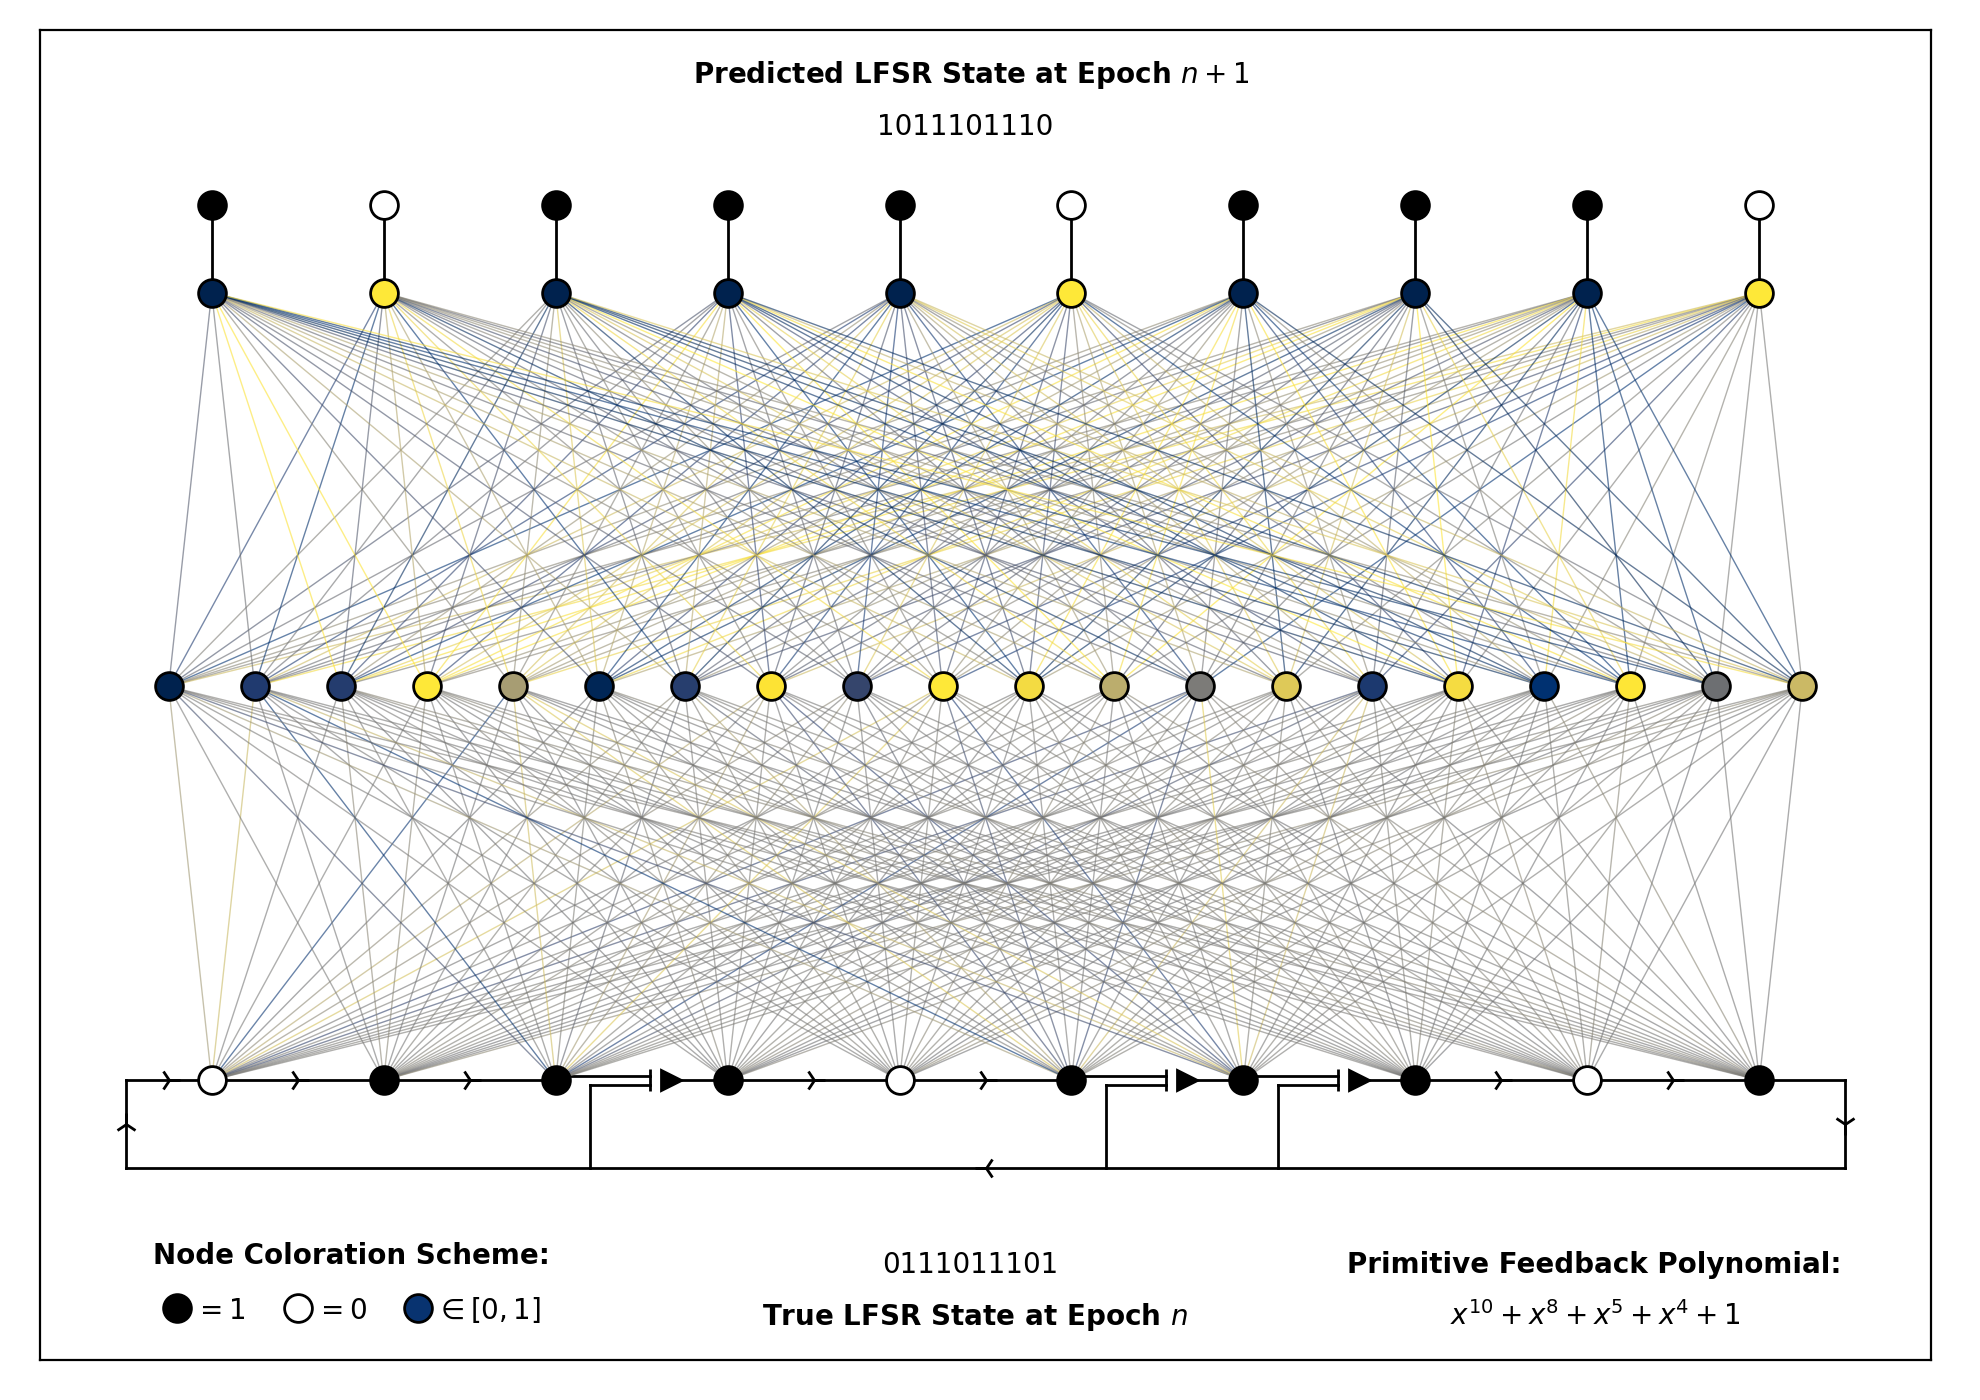

In [10]:
##############################
# Visualization config panel #
##############################

config = {
    'figsize': (9.9, 7),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'cividis',
    'y_input': 0,
    'y_hidden': 0.45,
    'y_output': 0.9,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'ylim': [-0.32, 1.2],
    'num_hidden': 2 * deg,
    'num_input': deg,
    'num_output': deg,
    'node_size': 10,
    'link_width': 1,
    'net_link_alpha': 0.6,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

lfsr_prediction_animation(
    lfsr=LFSRs[p], config=config, model=model,
    state_sequence=X, hidden_activations=hidden_activations,
    output_activations=output_activations,
    run_animation=True, interval=1000, blit=True, repeat=True)